## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import AlbertTokenizer
import transformers

from text_data import TextDataset5
from albert import CustomAlbert
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
train = pd.read_csv(f'{path}train.csv')

In [3]:
%%time
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 12 s, sys: 130 ms, total: 12.1 s
Wall time: 12.5 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2
TextDataset = TextDataset5

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_albert_2'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.q_albert, lr / 50, weight_decay)
        + get_optimizer_param_groups(model.a_albert, lr / 50, weight_decay)
    )

There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


Fold 1 started at Thu Feb  6 21:54:44 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


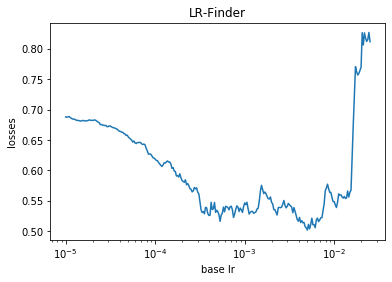

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49999 - spearmanr 0.26751
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.4739 - spearmanr 0.3794


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.3794
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45924 - spearmanr 0.38392
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45724 - spearmanr 0.40936
best model: epoch 1 - 0.40936
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43315 - spearmanr 0.45659
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45321 - spearmanr 0.41508
best model: epoch 2 - 0.41508
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40233 - spearmanr 0.53211
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45846 - spearmanr 0.41383
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41508
Starting inference for model: checkpoints/siamese_albert_2_fold_1_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_1_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 2 started at Thu Feb  6 22:34:11 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49991 - spearmanr 0.26586
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46965 - spearmanr 0.38486
best model: epoch 0 - 0.38486
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45853 - spearmanr 0.38389
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46316 - spearmanr 0.40711
best model: epoch 1 - 0.40711
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43247 - spearmanr 0.45618
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45518 - spearmanr 0.42155
best model: epoch 2 - 0.42155
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.39929 - spearmanr 0.5363
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45803 - spearmanr 0.41779
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42155
Starting inference for model: checkpoints/siamese_albert_2_fold_2_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_2_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 3 started at Thu Feb  6 23:12:38 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49903 - spearmanr 0.27371
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47142 - spearmanr 0.37198
best model: epoch 0 - 0.37198
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45982 - spearmanr 0.37909
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46286 - spearmanr 0.39175
best model: epoch 1 - 0.39175
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43595 - spearmanr 0.4452
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45704 - spearmanr 0.39934
best model: epoch 2 - 0.39934
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.4095 - spearmanr 0.5128
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45886 - spearmanr 0.39657
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39934
Starting inference for model: checkpoints/siamese_albert_2_fold_3_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_3_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 4 started at Thu Feb  6 23:50:36 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49857 - spearmanr 0.2717
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47007 - spearmanr 0.36299
best model: epoch 0 - 0.36299
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45759 - spearmanr 0.38986
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45548 - spearmanr 0.39606
best model: epoch 1 - 0.39606
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43224 - spearmanr 0.45902
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45479 - spearmanr 0.39958
best model: epoch 2 - 0.39958
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.39818 - spearmanr 0.54119
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46021 - spearmanr 0.3968
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39958
Starting inference for model: checkpoints/siamese_albert_2_fold_4_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_4_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 5 started at Fri Feb  7 00:28:22 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49916 - spearmanr 0.27419
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46724 - spearmanr 0.37682
best model: epoch 0 - 0.37682
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45904 - spearmanr 0.38627
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45474 - spearmanr 0.39335
best model: epoch 1 - 0.39335
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43256 - spearmanr 0.45812
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45211 - spearmanr 0.40013
best model: epoch 2 - 0.40013
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.39951 - spearmanr 0.5379
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45782 - spearmanr 0.40006
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40013
Starting inference for model: checkpoints/siamese_albert_2_fold_5_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_5_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 6 started at Fri Feb  7 01:06:07 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.5 - spearmanr 0.27063
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46601 - spearmanr 0.36114
best model: epoch 0 - 0.36114
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45981 - spearmanr 0.38464
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45247 - spearmanr 0.39356
best model: epoch 1 - 0.39356
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43371 - spearmanr 0.4552
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45121 - spearmanr 0.39979
best model: epoch 2 - 0.39979
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40121 - spearmanr 0.53569
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45261 - spearmanr 0.40218
best model: epoch 3 - 0.40218
TRAINING END: Best score achieved on epoch 3 - 0.40218
Starting inference for model: checkpoints/siamese_albert_2_fold_6_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_6_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 7 started at Fri Feb  7 01:43:53 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49952 - spearmanr 0.26832
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47874 - spearmanr 0.3654
best model: epoch 0 - 0.3654
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45904 - spearmanr 0.383
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46452 - spearmanr 0.39427
best model: epoch 1 - 0.39427
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43226 - spearmanr 0.4569
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45771 - spearmanr 0.41275
best model: epoch 2 - 0.41275
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.39898 - spearmanr 0.53705
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46046 - spearmanr 0.41316
best model: epoch 3 - 0.41316
TRAINING END: Best score achieved on epoch 3 - 0.41316
Starting inference for model: checkpoints/siamese_albert_2_fold_7_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_7_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 8 started at Fri Feb  7 02:21:40 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50034 - spearmanr 0.26388
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48032 - spearmanr 0.3739
best model: epoch 0 - 0.3739
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45819 - spearmanr 0.38275
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46841 - spearmanr 0.40371
best model: epoch 1 - 0.40371
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43119 - spearmanr 0.45859
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45968 - spearmanr 0.41898
best model: epoch 2 - 0.41898
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.39756 - spearmanr 0.54011
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46506 - spearmanr 0.41716
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41898
Starting inference for model: checkpoints/siamese_albert_2_fold_8_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_8_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 9 started at Fri Feb  7 02:59:24 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.49909 - spearmanr 0.27185
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46941 - spearmanr 0.36698
best model: epoch 0 - 0.36698
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46288 - spearmanr 0.37483
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.47369 - spearmanr 0.3634
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.45245 - spearmanr 0.41387
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45645 - spearmanr 0.40127
best model: epoch 2 - 0.40127
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41847 - spearmanr 0.49713
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.455 - spearmanr 0.40719
best model: epoch 3 - 0.40719
TRAINING END: Best score achieved on epoch 3 - 0.40719
Starting inference for model: checkpoints/siamese_albert_2_fold_9_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_9_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 10 started at Fri Feb  7 03:37:08 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50137 - spearmanr 0.26761
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47308 - spearmanr 0.3738
best model: epoch 0 - 0.3738
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45984 - spearmanr 0.38323
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45116 - spearmanr 0.40526
best model: epoch 1 - 0.40526
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43791 - spearmanr 0.44671
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44754 - spearmanr 0.41381
best model: epoch 2 - 0.41381
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40639 - spearmanr 0.52497
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.4477 - spearmanr 0.41689
best model: epoch 3 - 0.41689
TRAINING END: Best score achieved on epoch 3 - 0.41689
Starting inference for model: checkpoints/siamese_albert_2_fold_10_best.pth



Starting inference for model: checkpoints/siamese_albert_2_fold_10_best.pth



OOF score: 0.40738787453179076


In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomAlbert(256, cat_features_train.shape[1], head_dropout=0.2)
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [12]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 4 0.4776612582099725
5 4 0.45375527778356617
9 32 0.12750897627405564
11 8 0.7494048435417797
12 4 0.48731595006896083
13 32 0.21649238200780352
14 4 0.601529582356706
15 4 0.5633789515771976
16 16 0.7797770533257211
19 16 0.19989789748763023
24 8 0.16775765444941568


In [13]:
np.array(opt_ds), np.array(opt_indices)

(array([ 4,  4, 32,  8,  4, 32,  4,  4, 16, 16,  8]),
 array([ 2,  5,  9, 11, 12, 13, 14, 15, 16, 19, 24]))

In [14]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [15]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.407388
CV unique rows,0.371050
CV ignoring hard targets,0.430641
CV unique rows ignoring hard targets,0.391057
CV w rounding,0.434583
CV unique rows w rounding,0.409310
CV ignoring hard targets w rounding,0.453932
CV unique rows ignoring hard targets w rounding,0.422720


In [16]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.411296
CV unique rows,0.375126
CV ignoring hard targets,0.430641
CV unique rows ignoring hard targets,0.391057
CV w rounding,0.434583
CV unique rows w rounding,0.409448
CV ignoring hard targets w rounding,0.453932
CV unique rows ignoring hard targets w rounding,0.422720


In [17]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [18]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.746696,0.566937,0.342061,0.392319,0.594326,0.487661,0.647680,0.630233,0.719404,0.004906,0.623465,0.690144,0.019991,0.292766,0.011085,0.014054,0.066971,0.155808,0.849450,0.000587,0.794979,0.625577,0.257684,0.715290,0.791826,0.387072,0.012133,0.033143,0.865372,0.643052
1,46,0.482304,0.219370,0.004149,0.677159,0.664943,0.890408,0.381980,0.285026,0.157207,0.004443,0.506944,0.609399,0.001630,0.000673,0.000564,0.003791,0.864443,0.347108,0.140423,0.000058,0.291799,0.753576,0.463069,0.843177,0.893032,0.553710,0.892256,0.291509,0.117581,0.550540
2,70,0.648179,0.520231,0.029131,0.739914,0.800082,0.889637,0.498275,0.372789,0.174136,0.005779,0.311282,0.764099,0.005828,0.058819,0.001605,0.003030,0.124439,0.089004,0.763253,0.000265,0.681476,0.558144,0.290326,0.748417,0.726604,0.324368,0.050145,0.049700,0.919860,0.522249
3,132,0.537219,0.240042,0.007313,0.611302,0.617775,0.835336,0.372494,0.234704,0.196439,0.018599,0.570650,0.107322,0.003355,0.004821,0.001083,0.005980,0.808150,0.341385,0.530780,0.000223,0.414412,0.811958,0.612847,0.876540,0.902262,0.661509,0.800673,0.361785,0.636076,0.598281
4,200,0.770897,0.196998,0.049935,0.757188,0.717534,0.838326,0.659331,0.663710,0.272593,0.019168,0.388620,0.616837,0.010105,0.018400,0.005118,0.041508,0.222325,0.153336,0.657363,0.001646,0.418094,0.673621,0.510487,0.839126,0.822657,0.530011,0.356726,0.260690,0.495617,0.596993


In [19]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [20]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.812751,0.833507,0.239578,0.490187,0.623081,0.411703,0.651919,0.544023,0.128049,0.002400,0.614722,0.078410,0.236982,0.069767,0.004910,0.039933,0.162599,0.109962,0.686407,0.000336,0.862165,0.739392,0.503523,0.859783,0.829357,0.561293,0.144182,0.093957,0.809693,0.721306
1,0.813069,0.722125,0.127176,0.584490,0.913155,0.740625,0.510292,0.632722,0.332504,0.000964,0.308371,0.111338,0.922168,0.014551,0.410676,0.040160,0.013950,0.022531,0.450413,0.009014,0.792266,0.570787,0.285942,0.672994,0.786211,0.376347,0.008980,0.022749,0.555000,0.720873
2,0.480884,0.128742,0.008255,0.632755,0.740153,0.804148,0.442124,0.233326,0.242008,0.003683,0.421525,0.419123,0.022095,0.011022,0.002646,0.170485,0.608813,0.329259,0.229302,0.000157,0.399823,0.827582,0.536270,0.893533,0.905293,0.625157,0.557642,0.398618,0.584114,0.690673
3,0.732718,0.794920,0.149839,0.813965,0.759741,0.802337,0.602011,0.600258,0.188696,0.001930,0.296648,0.961348,0.032482,0.040209,0.031935,0.028406,0.029440,0.098586,0.461870,0.004921,0.806363,0.720015,0.659627,0.767810,0.846141,0.679697,0.055047,0.193273,0.805497,0.612246
4,0.836641,0.815739,0.001450,0.715024,0.860666,0.930852,0.551836,0.506037,0.163847,0.000260,0.220765,0.550096,0.000378,0.000185,0.000264,0.002877,0.905103,0.297621,0.063954,0.000005,0.851150,0.529783,0.352504,0.705046,0.856154,0.526687,0.909274,0.159915,0.008054,0.486823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.852046,0.412154,0.218411,0.792664,0.692060,0.717669,0.720312,0.741384,0.420422,0.005397,0.433840,0.885085,0.188215,0.098495,0.033343,0.108257,0.034991,0.082336,0.468355,0.007106,0.654938,0.801234,0.695366,0.863590,0.887127,0.657776,0.045271,0.057523,0.843979,0.694541
6075,0.809669,0.277490,0.075148,0.521715,0.508055,0.423960,0.649006,0.665053,0.133871,0.005263,0.733768,0.016938,0.023183,0.008420,0.001005,0.027235,0.799699,0.356735,0.180869,0.000088,0.635858,0.735290,0.575841,0.875563,0.856372,0.561480,0.699896,0.367927,0.390185,0.786329
6076,0.567508,0.540901,0.001597,0.672988,0.700871,0.914732,0.375270,0.262745,0.216315,0.001403,0.472132,0.601519,0.000369,0.000572,0.000182,0.001868,0.912288,0.389589,0.120890,0.000006,0.491422,0.628523,0.428127,0.865438,0.867494,0.442943,0.714167,0.235719,0.588890,0.622657
6077,0.760954,0.481756,0.670459,0.254786,0.297825,0.122764,0.610915,0.686390,0.894339,0.007205,0.912432,0.650717,0.236797,0.195087,0.044478,0.104225,0.095507,0.292508,0.758169,0.001224,0.786302,0.594842,0.342570,0.781888,0.753939,0.396475,0.035082,0.162127,0.732794,0.758012


In [21]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.381267
question_body_critical                   0.657839
question_conversational                  0.409098
question_expect_short_answer             0.288831
question_fact_seeking                    0.347904
question_has_commonly_accepted_answer    0.417818
question_interestingness_others          0.356474
question_interestingness_self            0.500215
question_multi_intent                    0.580516
question_not_really_a_question           0.094470
question_opinion_seeking                 0.463360
question_type_choice                     0.736400
question_type_compare                    0.356611
question_type_consequence                0.174856
question_type_definition                 0.359887
question_type_entity                     0.448941
question_type_instructions               0.777709
question_type_procedure                  0.354451
question_type_reason_explanation         0.667679
question_type_spelling                   0.069222


In [22]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.069222,3.0
question_not_really_a_question,0.094470,5.0
answer_plausible,0.152660,9.0
answer_relevance,0.163603,9.0
question_type_consequence,0.174856,5.0
answer_well_written,0.202683,9.0
answer_helpful,0.251887,9.0
question_expect_short_answer,0.288831,5.0
answer_type_procedure,0.294228,5.0
answer_satisfaction,0.337307,17.0


In [23]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

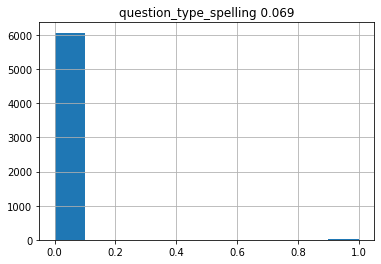

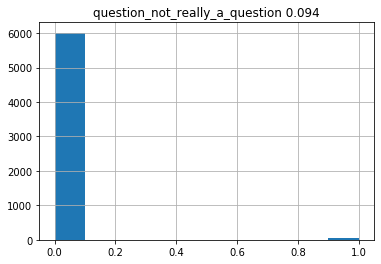

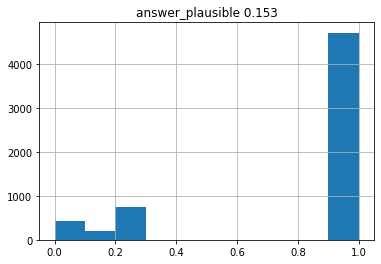

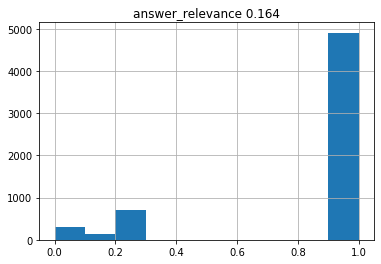

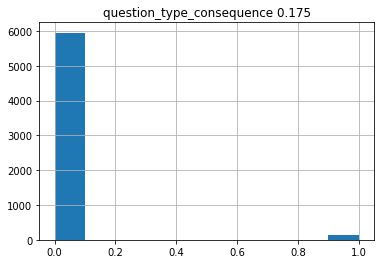

In [24]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


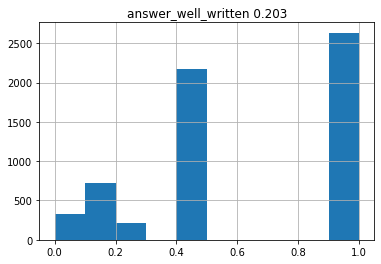

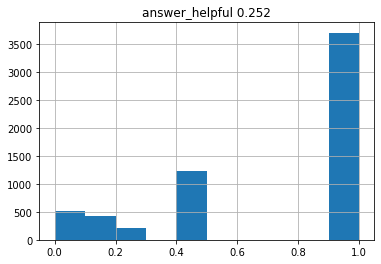

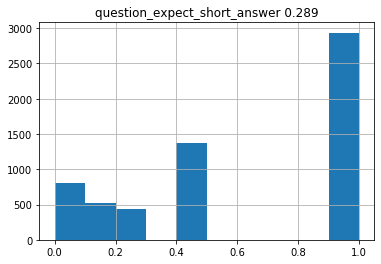

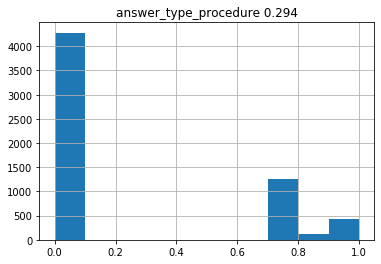

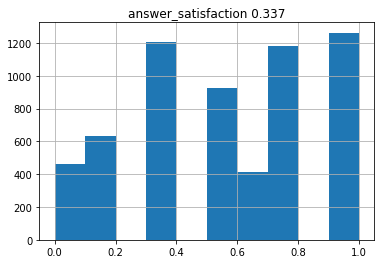

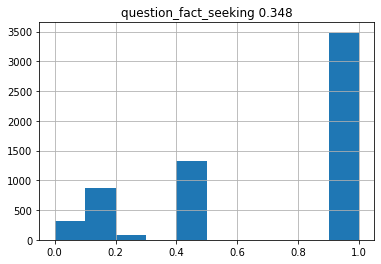

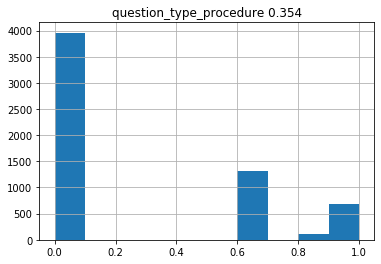

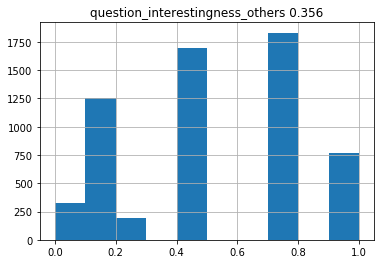

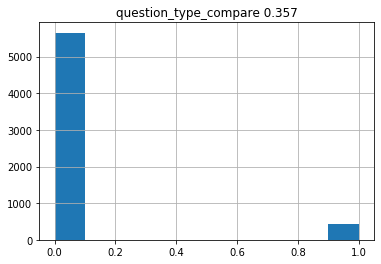

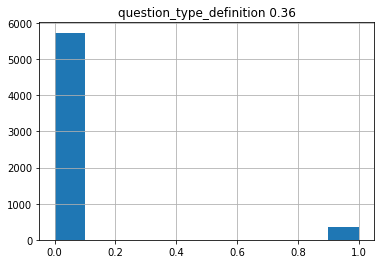

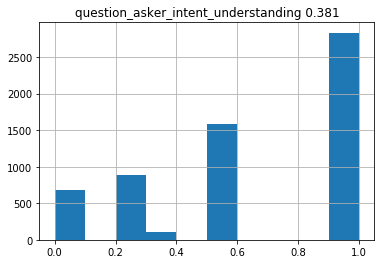

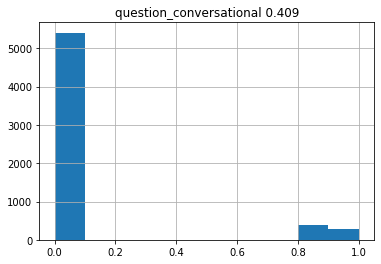

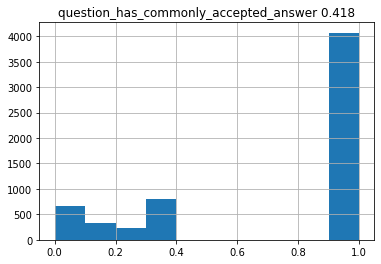

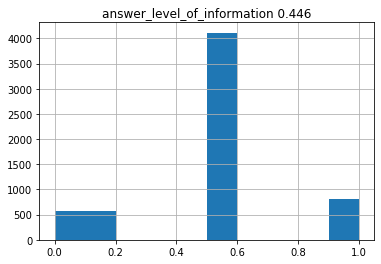

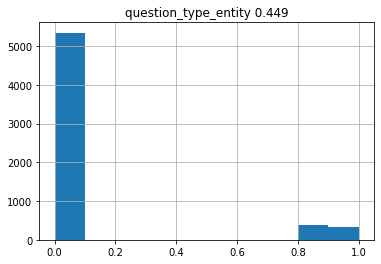

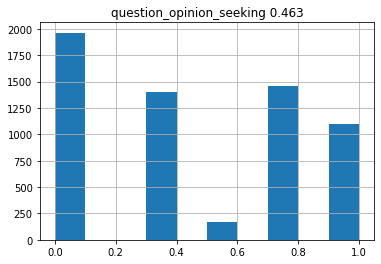

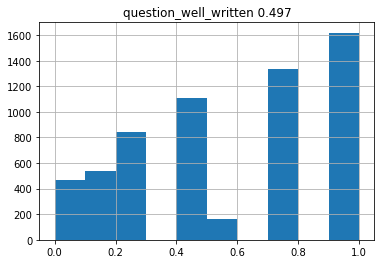

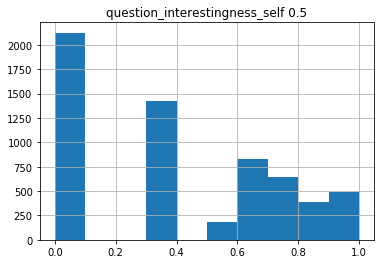

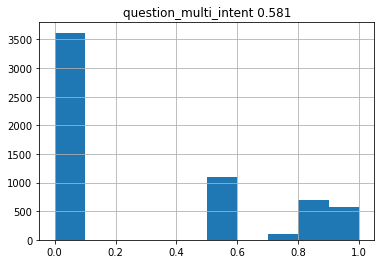

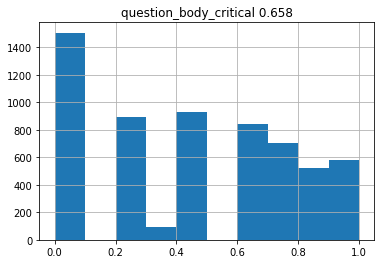

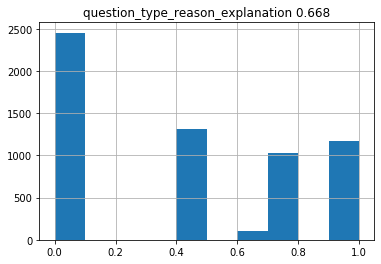

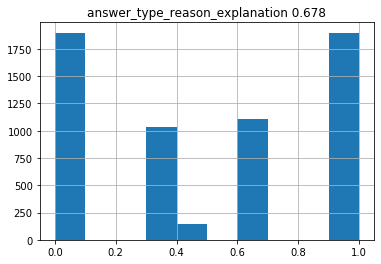

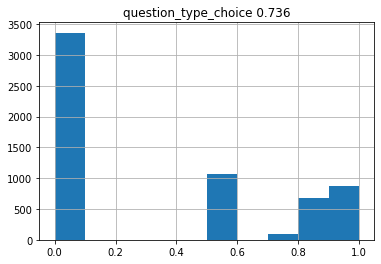

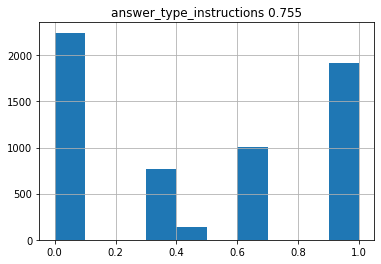

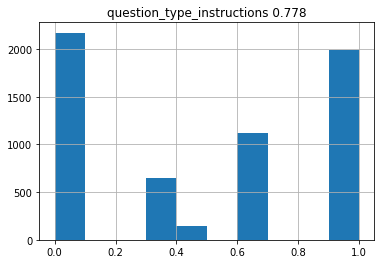

In [25]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')